In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
import csv
import time
from torch.amp import autocast, GradScaler

In [2]:
class TransformerTCN(nn.Module):
    """
    Advanced hybrid model combining Transformers and Temporal Convolutional Networks
    specifically optimized for Indian Sign Language recognition.
    """
    def __init__(self, input_size, num_classes, d_model=128, nhead=8, 
                 num_layers=3, dim_feedforward=512, dropout=0.3):
        super(TransformerTCN, self).__init__()
        
        # Initial feature projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_size, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Positional encoding for transformer
        self.register_buffer("positional_encoding", self._generate_positional_encoding(100, d_model))
        
        # Temporal Convolutional Network for local patterns
        self.tcn = nn.Sequential(
            nn.Conv1d(d_model, d_model*2, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm1d(d_model*2),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(d_model*2, d_model*2, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm1d(d_model*2),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(d_model*2, d_model, kernel_size=3, padding=4, dilation=4),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Special attention for difficult classes
        self.gesture_attention = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, num_classes)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
        # Gesture type discriminator - helps distinguish between similar signs
        self.gesture_discriminator = nn.Linear(d_model, num_classes)
        
    def _generate_positional_encoding(self, max_len, d_model):
        # Create standard sinusoidal positional encoding
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        
        pos_encoding = torch.zeros(max_len, d_model)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        
        return pos_encoding
        
    def forward(self, x):
        batch_size, seq_len, feat_dim = x.shape
        
        # Project input features to model dimension
        x = self.input_projection(x)  # [batch, seq_len, d_model]
        
        # Add positional encoding
        x = x + self.positional_encoding[:seq_len, :].unsqueeze(0)
        
        # Apply TCN for local patterns
        # Reshape for 1D convolution [batch, channels, length]
        tcn_input = x.permute(0, 2, 1)
        tcn_output = self.tcn(tcn_input)
        tcn_output = tcn_output.permute(0, 2, 1)  # Back to [batch, seq_len, d_model]
        
        # Residual connection with input
        transformer_input = x + tcn_output
        
        # Apply transformer encoder
        transformer_output = self.transformer_encoder(transformer_input)
        
        # Global representation - use attention-weighted pooling
        attn_weights = self.gesture_attention(transformer_output)  # [batch, seq_len, num_classes]
        
        # Apply softmax along sequence dimension
        attn_weights = F.softmax(attn_weights, dim=1)  # [batch, seq_len, num_classes]
        
        # Create per-class context vectors
        expanded_transformer = transformer_output.unsqueeze(2)  # [batch, seq_len, 1, d_model]
        expanded_attn = attn_weights.unsqueeze(3)  # [batch, seq_len, num_classes, 1]
        class_contexts = (expanded_transformer * expanded_attn).sum(dim=1)  # [batch, num_classes, d_model]
        
        # Get the mean representation across classes
        mean_context = class_contexts.mean(dim=1)  # [batch, d_model]
        
        # Generate main prediction
        main_logits = self.classifier(mean_context)
        
        # Generate auxiliary prediction for difficult gestures
        aux_logits = self.gesture_discriminator(mean_context)
        
        return main_logits, aux_logits, class_contexts

In [3]:
class GestureDataset(Dataset):
    def __init__(self, data_dir):
        """
        Initializes the dataset by scanning the provided directory for .npy files.
        Assumes filenames are formatted as "gestureLabel_index.npy".
        :param data_dir: Directory containing the processed .npy files.
        """
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]
        # Create a mapping from gesture labels to numeric indices.
        label_set = set()
        for f in self.file_paths:
            label = os.path.basename(f).split("_")[0]
            label_set.add(label)
        self.label2idx = {label: idx for idx, label in enumerate(sorted(label_set))}
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        """
        Loads a keypoint sequence and its label for a given index.
        :param idx: Index of the sample.
        :return: A tuple (sequence, label) where sequence is a tensor of shape (sequence_length, num_features)
                 and label is a tensor (numeric label).
        """
        file_path = self.file_paths[idx]
        sequence = np.load(file_path)  # Expected shape: (sequence_length, num_features)
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label_str = os.path.basename(file_path).split("_")[0]
        label = self.label2idx[label_str]
        label = torch.tensor(label, dtype=torch.long)
        return sequence, label


In [4]:
class FocalCosineLoss(nn.Module):
    """
    Combines Focal Loss and Cosine Embedding Loss for more effective training
    on difficult samples and similar gestures.
    """
    def __init__(self, alpha=0.25, gamma=2.0, class_weights=None, reduction='mean'):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
        self.reduction = reduction
        
    def forward(self, logits, target, class_contexts=None):
        # Convert logits to probabilities
        probs = F.softmax(logits, dim=1)
        
        # Get probability for the target class
        target_probs = probs.gather(1, target.unsqueeze(1)).squeeze(1)
        
        # Calculate focal weight
        focal_weight = (1 - target_probs) ** self.gamma
        
        # Apply class weights if provided
        if self.class_weights is not None:
            if isinstance(self.class_weights, torch.Tensor):
                weight = self.class_weights.gather(0, target)
            else:
                weight = torch.tensor([self.class_weights[t.item()] for t in target],
                                      device=target.device)
            focal_weight = focal_weight * weight
        
        # Calculate cross entropy
        ce_loss = F.cross_entropy(logits, target, reduction='none')
        
        # Apply focal weights
        focal_loss = focal_weight * ce_loss
        
        # Add cosine similarity loss for similar classes if class_contexts provided
        cos_loss = 0.0
        if class_contexts is not None:
            # Get embedding for the target class
            batch_indices = torch.arange(target.size(0), device=target.device)
            target_embed = class_contexts[batch_indices, target]
            
            
            # Calculate cosine similarity between all class pairs
            norm_contexts = F.normalize(class_contexts, p=2, dim=2)
            similarity = torch.bmm(norm_contexts, norm_contexts.transpose(1, 2))
            
            
            # We want similar classes to have lower similarity
            # Create a mask to ignore the target class
            mask = torch.ones_like(similarity, device=target.device)
            mask[batch_indices, target] = 0
            
            
            # Calculate loss - we want to minimize high similarities
            cos_loss = (similarity * mask).sum(dim=(1, 2)) / (mask.sum(dim=(1, 2)) + 1e-8)
            
        # Combine losses
        loss = focal_loss + 0.2 * cos_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [5]:
def train_advanced_model(data_dir, num_epochs=50,batch_size=16, learning_rate=0.001, 
                       model_version="transformer_tcn"):
    """
    Advanced training function with:
    - Mixed precision training
    - Learning rate warmup & cosine decay
    - Focal Cosine Loss
    - Confusion matrix monitoring
    - Per-class performance tracking
    """
    # Create dataset
    print("Loading dataset...")
    dataset = GestureDataset(data_dir)
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Get sample dimensions
    sample = dataset[0]
    sample_seq, _ = sample
    input_size = sample_seq.shape[1]
    num_classes = len(dataset.label2idx)
    
    print(f"Input size: {input_size}, Classes: {num_classes}")
    
    # Create model
    model = TransformerTCN(
        input_size=input_size,
        num_classes=num_classes,
        d_model=128,
        nhead=8,
        num_layers=3
    )
    
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Compute class weights for loss function
    class_counts = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        label_idx = label.item()
        class_counts[label_idx] = class_counts.get(label_idx, 0) + 1
    
    # Convert counts to weights (inverse frequency)
    class_weights = {idx: len(dataset) / (count * num_classes) 
                    for idx, count in class_counts.items()}
    
    # Convert to tensor for easier handling
    weight_tensor = torch.zeros(num_classes, device=device)
    for idx, weight in class_weights.items():
        weight_tensor[idx] = weight
    
    # Create loss function
    criterion = FocalCosineLoss(alpha=0.25, gamma=2.0, class_weights=weight_tensor)
    
    # Create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Learning rate scheduler with warmup
    def lr_lambda(epoch):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            # Cosine decay from 1.0 to 0.1 over remaining epochs
            return 0.1 + 0.9 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs))) / 2
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    # Create logging directory
    os.makedirs(os.path.join("..", "logs"), exist_ok=True)
    os.makedirs(os.path.join("..", "graphs"), exist_ok=True)
    log_file = os.path.join("..", "logs", f"training_log_{model_version}.csv")
    with open(log_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", 
                         "sorry_acc", "practice_acc", "learning_rate"])
    
    # Training loop
    best_val_loss = float('inf')
    # difficult_classes = ["sorry", "practice"]  # The classes we want to track specifically
    # difficult_class_indices = [dataset.label2idx.get(label, -1) for label in difficult_classes]
    
    print(f"Training on {device} with {len(train_dataset)} samples...")
    # print(f"Difficult classes to track: {difficult_classes}")
    
    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Progress tracking
        batch_time = time.time()
        
        for i, (sequences, labels) in enumerate(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            if scaler:
                with autocast('cuda'):
                    main_logits, aux_logits, class_contexts = model(sequences)
                    loss = criterion(main_logits, labels, class_contexts) + 0.3 * criterion(aux_logits, labels)
                
                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard forward pass
                main_logits, aux_logits, class_contexts = model(sequences)
                loss = criterion(main_logits, labels, class_contexts) + 0.3 * criterion(aux_logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # Update metrics
            train_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(main_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Print batch progress every 5 batches
            if (i + 1) % 5 == 0:
                batch_acc = 100 * (predicted == labels).sum().item() / labels.size(0)
                batch_time = time.time() - batch_time
                print(f"Epoch {epoch}, Batch {i+1}/{len(train_loader)}: "
                      f"Loss: {loss.item():.4f}, Acc: {batch_acc:.2f}%, "
                      f"Time: {batch_time:.2f}s")
                batch_time = time.time()
        
        # Calculate epoch metrics
        train_loss /= total
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Track difficult classes
        # difficult_correct = {idx: 0 for idx in difficult_class_indices}
        # difficult_total = {idx: 0 for idx in difficult_class_indices}
        
        # For confusion matrix
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                
                # Forward pass
                main_logits, aux_logits, class_contexts = model(sequences)
                loss = criterion(main_logits, labels, class_contexts)
                
                # Weighted ensemble of main and auxiliary predictions
                ensemble_logits = main_logits + 0.3 * aux_logits
                _, predicted = torch.max(ensemble_logits, 1)
                
                # Update metrics
                val_loss += loss.item() * sequences.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # Store predictions for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Track performance on difficult classes
                # for idx in difficult_class_indices:
                #     mask = (labels == idx)
                #     if mask.sum() > 0:
                #         difficult_total[idx] += mask.sum().item()
                #         difficult_correct[idx] += ((predicted == labels) & mask).sum().item()
        
        # Calculate validation metrics
        val_loss /= total_val
        val_acc = 100 * correct_val / total_val
        
        # Calculate accuracy for difficult classes
        # difficult_accs = {}
        # for idx in difficult_class_indices:
        #     if difficult_total[idx] > 0:
        #         difficult_accs[idx] = 100 * difficult_correct[idx] / difficult_total[idx]
        #     else:
        #         difficult_accs[idx] = 0.0
        
        # Get current learning rate
        current_lr = scheduler.get_last_lr()[0]
        
        # Print epoch results
        print(f"\nEpoch {epoch}/{num_epochs} - LR: {current_lr:.6f}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Print difficult class accuracies
        # for i, idx in enumerate(difficult_class_indices):
        #     class_name = difficult_classes[i]
        #     if idx >= 0:  # Valid class index
        #         print(f"  {class_name} accuracy: {difficult_accs[idx]:.2f}%")
        
        # Log metrics
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            # sorry_acc = difficult_accs.get(dataset.label2idx.get("sorry", -1), 0)
            # practice_acc = difficult_accs.get(dataset.label2idx.get("practice", -1), 0)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, 
                             sorry_acc, practice_acc, current_lr])
        
        # Generate and save confusion matrix every 10 epochs
        if epoch % 10 == 0 or epoch == num_epochs:
            cm = confusion_matrix(all_labels, all_preds)
            
            # Get class names in order
            idx_to_label = {v: k for k, v in dataset.label2idx.items()}
            class_names = [idx_to_label[i] for i in range(num_classes)]
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.title(f'Confusion Matrix - Epoch {epoch}')
            plt.tight_layout()
            plt.savefig(os.path.join("..", "graphs", f"confusion_matrix_epoch_{epoch}.png"))
            plt.close()
        
        # Update learning rate
        scheduler.step()
        
        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.join("..", "models"), exist_ok=True)
            checkpoint_path = os.path.join("..", "models", f"gesture_model_{model_version}.pt")
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'input_size': input_size,
                'num_classes': num_classes,
                'label_map': dataset.label2idx
            }, checkpoint_path)
            
            print(f"Model improved! Saved checkpoint to {checkpoint_path}")
    
    print("Training complete!")
    
    # Generate final plots
    log_df = pd.read_csv(log_file)
    
    # Plot losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss')
    plt.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(log_df['epoch'], log_df['train_acc'], label='Train Acc')
    plt.plot(log_df['epoch'], log_df['val_acc'], label='Val Acc')
    if 'sorry_acc' in log_df.columns:
        plt.plot(log_df['epoch'], log_df['sorry_acc'], label='Sorry Acc')
    if 'practice_acc' in log_df.columns:
        plt.plot(log_df['epoch'], log_df['practice_acc'], label='Practice Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join("..", "graphs", f"training_curves_{model_version}.png"))
    plt.show()
    
    return model

In [6]:
def extract_enhanced_keypoints(frame, holistic):
    """Extract enhanced keypoints with MediaPipe Holistic"""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(frame_rgb)
    
    features = []
    
    # Left hand landmarks
    left_hand = []
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            left_hand.extend([lm.x, lm.y, lm.z])
    else:
        left_hand = [0] * (21 * 3)
        
    # Right hand landmarks
    right_hand = []
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            right_hand.extend([lm.x, lm.y, lm.z])
    else:
        right_hand = [0] * (21 * 3)
    
    # Extract key face landmarks for hand-face interactions
    face = []
    if results.face_landmarks:
        # Extract key points from face (lips, nose, eyes)
        key_face_points = [0, 13, 14, 17, 37, 267, 291, 314, 346, 375]
        for idx in key_face_points:
            lm = results.face_landmarks.landmark[idx]
            face.extend([lm.x, lm.y, lm.z])
    else:
        face = [0] * (10 * 3)
    
    # Combine features
    features.extend(left_hand)
    features.extend(right_hand)
    features.extend(face)
    
    return np.array(features), results

In [7]:
def run_real_time_advanced_prediction():
    """
    Real-time prediction with advanced techniques for difficult gesture recognition:
    - Ensemble of main and auxiliary outputs
    - Gesture-specific confidence thresholds
    - Temporal consistency checking
    - Visual feedback on recognition confidence
    """
    mp_holistic = mp.solutions.holistic
    mp_drawing = mp.solutions.drawing_utils
    
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(os.path.join("..", "models", "gesture_model_transformer_tcn.pt"), 
                           map_location=device, weights_only=False)
    
    # Get expected input size
    expected_input_size = checkpoint['input_size']
    print(f"Model expects input size: {expected_input_size}")
    
    # Create model
    model = TransformerTCN(
        input_size=expected_input_size,
        num_classes=checkpoint['num_classes'],
        d_model=128,
        nhead=8,
        num_layers=3
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Create label mapping
    label_map = {v: k for k, v in checkpoint['label_map'].items()}
    print(f"Loaded {len(label_map)} gesture classes: {', '.join(label_map.values())}")
    
    # Setup camera and sequence variables
    cap = cv2.VideoCapture(0)
    sequence = []
    sequence_length = 30
    prev_features = None
    
    # Prediction stabilization
    prediction_buffer = []
    buffer_size = 8  # Larger buffer for more stability
    prediction_history = {}  # Track confidence per class over time
    current_prediction = None
    prediction_cooldown = 0
    
    # Class-specific confidence thresholds
    confidence_thresholds = {
        'sorry': 0.85,       # Higher threshold for difficult gestures
        'practice': 0.85,
        'default': 0.70      # Default threshold for other gestures
    }
    
    # Setup holistic model
    with mp_holistic.Holistic(
        model_complexity=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.7) as holistic:
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Mirror frame for more intuitive interaction
            frame = cv2.flip(frame, 1)
            
            # Extract features
            features, results = extract_enhanced_keypoints(frame, holistic)
            
            # Calculate velocity features
            if prev_features is not None:
                velocity = features - prev_features
                features_with_vel = np.concatenate([features, velocity])
            else:
                velocity = np.zeros_like(features)
                features_with_vel = np.concatenate([features, velocity])
            
            prev_features = features
            
            # Check for hand presence
            hand_detected = (np.max(np.abs(features[:126])) > 0.05)
            
            if hand_detected:
                # Ensure correct input size
                if len(features_with_vel) < expected_input_size:
                    padding = np.zeros(expected_input_size - len(features_with_vel))
                    features_with_vel = np.concatenate([features_with_vel, padding])
                elif len(features_with_vel) > expected_input_size:
                    features_with_vel = features_with_vel[:expected_input_size]
                
                # Add to sequence
                sequence.append(features_with_vel)
                if len(sequence) > sequence_length:
                    sequence.pop(0)
                
                # Make prediction with both outputs
                if len(sequence) == sequence_length and prediction_cooldown <= 0:
                    input_seq = np.array(sequence)
                    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        main_logits, aux_logits, class_contexts = model(input_seq)
                        
                        # Ensemble prediction with weighted auxiliary output
                        ensemble_logits = main_logits + 0.3 * aux_logits
                        probabilities = torch.softmax(ensemble_logits, dim=1)[0]
                        
                        # Get top 3 predictions with confidences
                        top_values, top_indices = torch.topk(probabilities, k=3)
                        
                        # Get predictions and confidences
                        predictions = [(label_map[idx.item()], val.item()) 
                                      for idx, val in zip(top_indices, top_values)]
                        
                        # Add to buffer for stabilization
                        prediction_buffer.append(predictions[0])  # Add top prediction
                        if len(prediction_buffer) > buffer_size:
                            prediction_buffer.pop(0)
                        
                        # Count occurrences and track confidence by class
                        gesture_counts = {}
                        gesture_confidences = {}
                        
                        for gesture, conf in prediction_buffer:
                            gesture_counts[gesture] = gesture_counts.get(gesture, 0) + 1
                            
                            if gesture not in gesture_confidences:
                                gesture_confidences[gesture] = []
                            gesture_confidences[gesture].append(conf)
                        
                        # Find most common gesture with adequate confidence
                        if gesture_counts:
                            # Sort by count, then by average confidence
                            sorted_gestures = sorted(
                                [(g, gesture_counts[g], sum(gesture_confidences[g])/len(gesture_confidences[g])) 
                                 for g in gesture_counts],
                                key=lambda x: (x[1], x[2]),
                                reverse=True
                            )
                            
                            # Get top gesture and its data
                            top_gesture, count, avg_conf = sorted_gestures[0]
                            
                            # Check if it meets the threshold (different for difficult gestures)
                            threshold = confidence_thresholds.get(top_gesture, confidence_thresholds['default'])
                            buffer_ratio = count / buffer_size
                            
                            # Update prediction if meets criteria
                            if buffer_ratio >= 0.6 and avg_conf >= threshold:
                                current_prediction = top_gesture
                                prediction_cooldown = 5  # Set cooldown to prevent flickering
                                
                                # Store in history for persistent display
                                if top_gesture not in prediction_history:
                                    prediction_history[top_gesture] = []
                                prediction_history[top_gesture].append(avg_conf)
                                
                                # Keep history limited
                                if len(prediction_history[top_gesture]) > 10:
                                    prediction_history[top_gesture].pop(0)
            
            # Decrement cooldown
            if prediction_cooldown > 0:
                prediction_cooldown -= 1
            
            # Drawing and UI
            # Clear overlay area for text
            overlay = frame.copy()
            cv2.rectangle(overlay, (0, 0), (frame.shape[1], 100), (0, 0, 0), -1)
            frame = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)
            
            if current_prediction:
                # Show prediction with larger text for better visibility
                cv2.putText(
                    frame, 
                    current_prediction, 
                    (20, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    2.0,  # Larger font
                    (0, 255, 0), 
                    3
                )
                
                # Show confidence if available
                if current_prediction in prediction_history and prediction_history[current_prediction]:
                    conf = sum(prediction_history[current_prediction]) / len(prediction_history[current_prediction])
                    cv2.putText(
                        frame,
                        f"Confidence: {conf:.2f}",
                        (20, 95),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.8,
                        (0, 255, 0),
                        2
                    )
            else:
                cv2.putText(
                    frame,
                    "Waiting for gesture...",
                    (20, 60),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0,
                    (255, 255, 255),
                    2
                )
            
            # Draw landmarks with improved visibility
            if results.right_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame, 
                    results.right_hand_landmarks, 
                    mp_holistic.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
                )
            if results.left_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame, 
                    results.left_hand_landmarks, 
                    mp_holistic.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
                )
            
            # Show instruction text
            cv2.putText(
                frame,
                "Press ESC to quit",
                (frame.shape[1] - 200, frame.shape[0] - 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 255, 255),
                2
            )
            
            # Display frame
            cv2.imshow('Advanced ISL Recognition', frame)
            if cv2.waitKey(5) & 0xFF == 27:  # ESC to quit
                break
                
    cap.release()
    cv2.destroyAllWindows()

In [8]:
DATA_DIR = os.path.join("..", "data", "processed")

# Training
print("Starting advanced model training...")
model = train_advanced_model(DATA_DIR)

# Run real-time prediction
print("\nStarting real-time prediction...")


Starting advanced model training...
Loading dataset...
Input size: 342, Classes: 7


C:\Users\beana\AppData\Local\Temp\ipykernel_41292\2808871522.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


Training on cuda with 1176 samples...
Difficult classes to track: ['sorry', 'practice']
Epoch 1, Batch 5/74: Loss: 2.1822, Acc: 18.75%, Time: 1.18s
Epoch 1, Batch 10/74: Loss: 2.3626, Acc: 6.25%, Time: 0.09s
Epoch 1, Batch 15/74: Loss: 2.1275, Acc: 6.25%, Time: 0.10s
Epoch 1, Batch 20/74: Loss: 2.1022, Acc: 12.50%, Time: 0.10s
Epoch 1, Batch 25/74: Loss: 2.2904, Acc: 6.25%, Time: 0.08s
Epoch 1, Batch 30/74: Loss: 2.3145, Acc: 0.00%, Time: 0.08s
Epoch 1, Batch 35/74: Loss: 2.0094, Acc: 12.50%, Time: 0.09s
Epoch 1, Batch 40/74: Loss: 2.1830, Acc: 6.25%, Time: 0.08s
Epoch 1, Batch 45/74: Loss: 2.0939, Acc: 18.75%, Time: 0.10s
Epoch 1, Batch 50/74: Loss: 2.0768, Acc: 18.75%, Time: 0.10s
Epoch 1, Batch 55/74: Loss: 2.2438, Acc: 6.25%, Time: 0.10s
Epoch 1, Batch 60/74: Loss: 2.1064, Acc: 18.75%, Time: 0.09s
Epoch 1, Batch 65/74: Loss: 2.0232, Acc: 12.50%, Time: 0.08s
Epoch 1, Batch 70/74: Loss: 1.9379, Acc: 25.00%, Time: 0.09s

Epoch 1/100 - LR: 0.000000
Train Loss: 2.1289, Train Acc: 14.63%

KeyboardInterrupt: 

In [14]:
run_real_time_advanced_prediction()

Model expects input size: 342
Loaded 7 gesture classes: bye, hello, namaste, practice, sorry, thankyou, welcome


In [11]:
def plot_training_results(log_file=None, model_version="transformer_tcn"):
    """
    Generate plots from training logs to visualize model performance
    with focus on difficult gestures
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set plot style
    sns.set(style="whitegrid")
    
    # Use default log file path if none provided
    if log_file is None:
        log_file = os.path.join("..", "logs", f"training_log_{model_version}.csv")
    
    # Create output directory for graphs
    os.makedirs(os.path.join("..", "graphs"), exist_ok=True)
    
    # Load the log data
    log_df = pd.read_csv(log_file)
    print(f"Loaded log with {len(log_df)} epochs")
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Training and validation loss/accuracy
    ax1.plot(log_df['epoch'], log_df['train_loss'], 'b-', label='Train Loss')
    ax1.plot(log_df['epoch'], log_df['val_loss'], 'b--', label='Val Loss')
    
    # Create second y-axis for accuracy
    ax1_2 = ax1.twinx()
    ax1_2.plot(log_df['epoch'], log_df['train_acc'], 'r-', label='Train Acc')
    ax1_2.plot(log_df['epoch'], log_df['val_acc'], 'r--', label='Val Acc')
    
    # Set labels
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1_2.set_ylabel('Accuracy (%)', color='r')
    ax1.set_title('Model Learning Curves')
    
    # Add combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center')
    
    # Plot 2: Difficult class tracking
    ax2.plot(log_df['epoch'], log_df['val_acc'], 'k-', label='Overall Accuracy')
    
    # Add specific class tracking if available
    for cls in ['sorry', 'practice']:
        col = f"{cls}_acc"
        if col in log_df.columns:
            ax2.plot(log_df['epoch'], log_df[col], label=f'{cls.capitalize()} Accuracy')
    
    # Set labels
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Difficult Class Performance')
    ax2.legend()
    
    # Layout and save
    plt.tight_layout()
    plt.savefig(os.path.join("..", "graphs", f"training_results_{model_version}.png"))
    plt.show()
    
    print(f"Plot saved to ../graphs/training_results_{model_version}.png")
    
    # Give quick insight about difficult classes
    if 'sorry_acc' in log_df.columns and 'practice_acc' in log_df.columns:
        last_epoch = log_df.iloc[-1]
        print(f"\nFinal results:")
        print(f"Overall accuracy: {last_epoch['val_acc']:.2f}%")
        print(f"Sorry accuracy: {last_epoch['sorry_acc']:.2f}%")
        print(f"Practice accuracy: {last_epoch['practice_acc']:.2f}%")
        
        # Calculate gap between overall and class-specific
        sorry_gap = last_epoch['val_acc'] - last_epoch['sorry_acc']
        practice_gap = last_epoch['val_acc'] - last_epoch['practice_acc']
        
        print(f"Performance gap for 'sorry': {sorry_gap:.2f}%")
        print(f"Performance gap for 'practice': {practice_gap:.2f}%")
    
    return log_df

Loaded log with 100 epochs


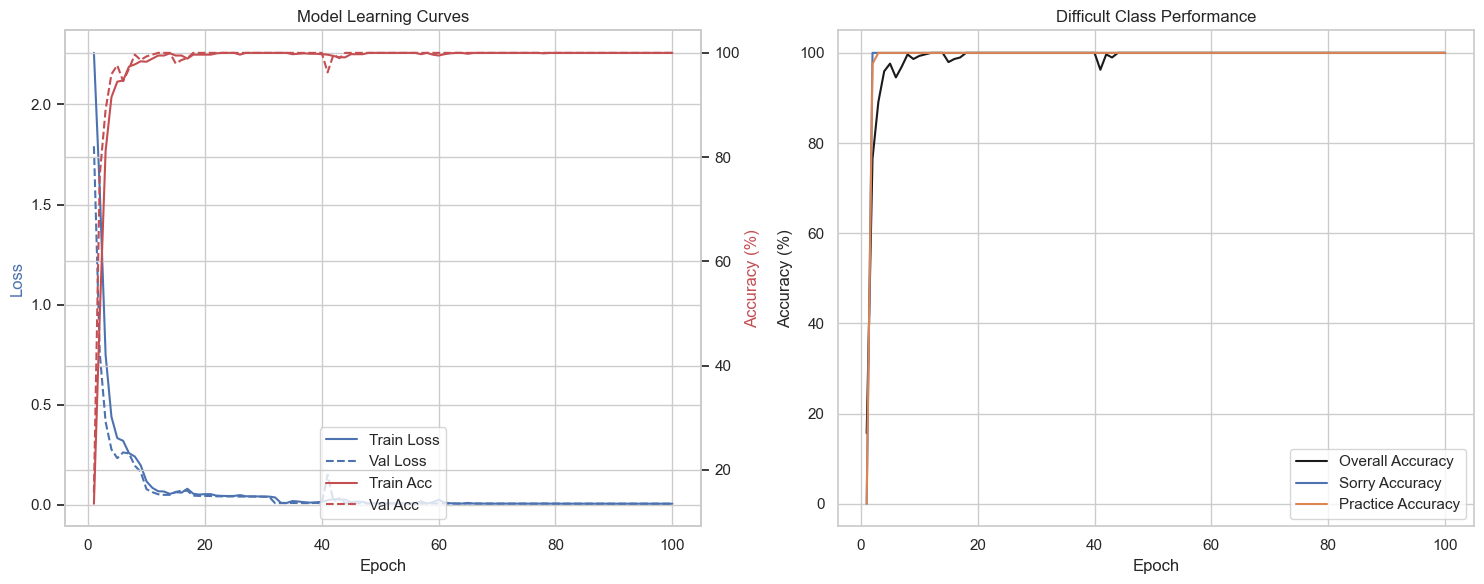

Plot saved to ../graphs/training_results_transformer_tcn.png

Final results:
Overall accuracy: 100.00%
Sorry accuracy: 100.00%
Practice accuracy: 100.00%
Performance gap for 'sorry': 0.00%
Performance gap for 'practice': 0.00%


,epoch,train_loss,train_acc,val_loss,val_acc,sorry_acc,practice_acc,learning_rate
0,1,2.257570,13.520408,1.791119,15.646259,0.0,0.000000,0.000000
1,2,1.573445,49.574830,0.757629,76.530612,100.0,97.560976,0.000060
2,3,0.748592,81.207483,0.413956,89.115646,100.0,100.000000,0.000120
3,4,0.439402,91.496599,0.276480,95.918367,100.0,100.000000,0.000180
4,5,0.332982,94.472789,0.233011,97.619048,100.0,100.000000,0.000240
...,...,...,...,...,...,...,...,...
95,96,0.005472,100.000000,0.005669,100.000000,100.0,100.000000,0.000032
96,97,0.005500,100.000000,0.005673,100.000000,100.0,100.000000,0.000031
97,98,0.005454,100.000000,0.005661,100.000000,100.0,100.000000,0.000031
98,99,0.005464,100.000000,0.005636,100.000000,100.0,100.000000,0.000030


In [12]:
# After training is complete, visualize the results
plot_training_results()